### Environment

In [513]:
TRAIN_DATA_PATH = '../data/train.csv'
TEST_DATA_PATH = '../data/test.csv'

LEARNING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 100

### Add Watermarks

In [514]:
import random
import numpy as np
def add_watermark(images):
    images_with_watermark = np.copy(images)
    images_with_watermark = images_with_watermark.reshape(-1, 28, 28)
    num_images = len(images_with_watermark)
    
    mask = np.zeros((num_images, 28, 28), dtype=bool)
    for i in range(num_images):
        num_masks = random.randint(1, 10)
        for _ in range(num_masks):
            shapes = [[2,12], [12,2], [8,4], [4,8]]
            shape = random.choice(shapes)
            watermark_w = shape[0]
            watermark_h = shape[1]
            watermark_x = random.randint(0, 28)
            watermark_y = random.randint(0, 28)
            mask[i, watermark_x:watermark_x + watermark_w, watermark_y:watermark_y + watermark_h] = True

    images_with_watermark[mask] = 255   
    images_with_watermark = images_with_watermark.reshape(-1, 784)
    return images_with_watermark


### Load data

Loaded train adn test data.
xs_train shape torch.Size([42000, 1, 28, 28])
ys_train shape torch.Size([42000, 1, 28, 28])
xs_test  shape torch.Size([28000, 1, 28, 28])
ys_test  shape torch.Size([28000, 1, 28, 28])


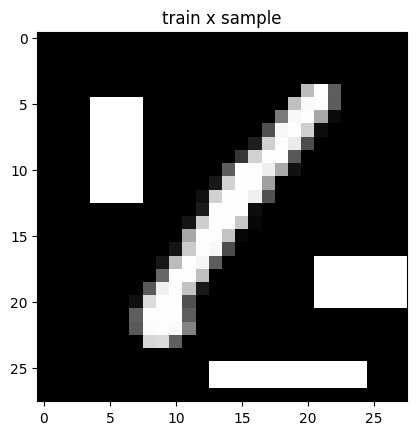

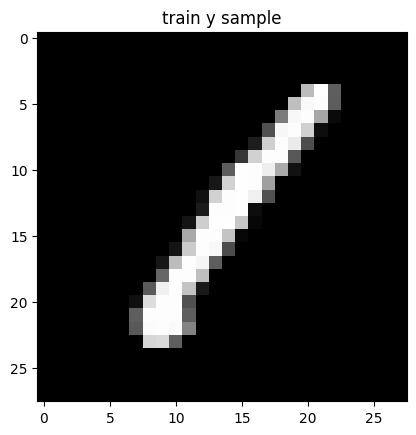

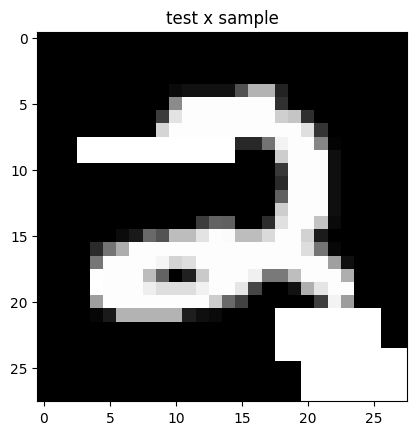

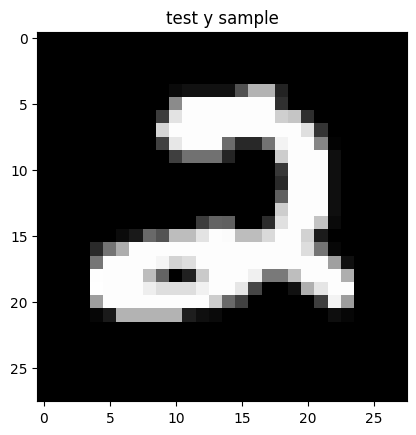

In [522]:
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple
from pandas import DataFrame, Series

def load_train_data() -> Tuple[DataFrame, Series]:
    df: DataFrame = pd.read_csv(TRAIN_DATA_PATH)
    xs: DataFrame = df.iloc[:, 1:]
    ys: Series = df.iloc[:, 0]
    return xs, ys

def load_test_data() -> DataFrame:
    xs: DataFrame = pd.read_csv(TEST_DATA_PATH)
    return xs

def df_to_tensor(df: DataFrame) -> Tensor:
    tensor = torch.tensor(df.values, dtype=torch.float32)
    tensor /= 255.0
    return tensor.reshape(-1, 1, 28, 28)

def np_to_tensor(np_array: np.ndarray) -> Tensor:
    tensor = torch.tensor(np_array, dtype=torch.float32)
    tensor /= 255.0
    return tensor.reshape(-1, 1, 28, 28)

def plot_image(image, title):
    plt.figure()
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.title(title)
    plt.show()

xs_train_df, _ = load_train_data()
xs_test_df = load_test_data()

xs_train_with_watermark = add_watermark(xs_train_df.values)
xs_test_with_watermark = add_watermark(xs_test_df.values)

xs_train = np_to_tensor(xs_train_with_watermark)
ys_train = df_to_tensor(xs_train_df)
xs_test = np_to_tensor(xs_test_with_watermark)
ys_test = df_to_tensor(xs_test_df)

print('Loaded train adn test data.')
print(f'xs_train shape {xs_train.shape}')
print(f'ys_train shape {ys_train.shape}')
print(f'xs_test  shape {xs_test.shape}')
print(f'ys_test  shape {ys_test.shape}')
plot_image(xs_train[0], 'train x sample')
plot_image(ys_train[0], 'train y sample')
plot_image(xs_test[0],  'test x sample')
plot_image(ys_test[0],  'test y sample')

### Model

In [544]:
from torch import nn, optim

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

### Train

In [546]:
def get_batches(xs, ys, batch_size):
    for i in range(0, len(xs), batch_size):
        yield xs[i:i + batch_size], ys[i:i + batch_size]

def train(device, model, xs_train, ys_train):
    model.to(device)
    model.train()
    xs_train = xs_train.to(device)
    ys_train = ys_train.to(device)

    for epoch in range(EPOCHS):
        permutation = torch.randperm(xs_train.size(0))
        xs_train_shuffled = xs_train[permutation]
        ys_train_shufflex = ys_train[permutation]
        
        for (xs, ys_true) in get_batches(xs_train_shuffled, ys_train_shufflex, BATCH_SIZE):                      
            ys_pred = model(xs)
            loss = criterion(ys_pred, ys_true)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        print(f'Epoch [{'0' if epoch+1 < 10 else ''}{epoch+1}/{EPOCHS}], Loss: {loss.item():.4f}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train(device, model, xs_train, ys_train)

cuda
Epoch [01/100], Loss: 0.0120
Epoch [02/100], Loss: 0.0088
Epoch [03/100], Loss: 0.0080
Epoch [04/100], Loss: 0.0093
Epoch [05/100], Loss: 0.0093
Epoch [06/100], Loss: 0.0089
Epoch [07/100], Loss: 0.0079
Epoch [08/100], Loss: 0.0100
Epoch [09/100], Loss: 0.0073
Epoch [10/100], Loss: 0.0055
Epoch [11/100], Loss: 0.0063
Epoch [12/100], Loss: 0.0082
Epoch [13/100], Loss: 0.0059
Epoch [14/100], Loss: 0.0060
Epoch [15/100], Loss: 0.0069
Epoch [16/100], Loss: 0.0085
Epoch [17/100], Loss: 0.0064
Epoch [18/100], Loss: 0.0071
Epoch [19/100], Loss: 0.0054
Epoch [20/100], Loss: 0.0049
Epoch [21/100], Loss: 0.0056
Epoch [22/100], Loss: 0.0059
Epoch [23/100], Loss: 0.0062
Epoch [24/100], Loss: 0.0051
Epoch [25/100], Loss: 0.0066
Epoch [26/100], Loss: 0.0067
Epoch [27/100], Loss: 0.0057
Epoch [28/100], Loss: 0.0066
Epoch [29/100], Loss: 0.0052
Epoch [30/100], Loss: 0.0071
Epoch [31/100], Loss: 0.0043
Epoch [32/100], Loss: 0.0064
Epoch [33/100], Loss: 0.0052
Epoch [34/100], Loss: 0.0069
Epoch [35

# Evaluate

Test Loss: 0.0059


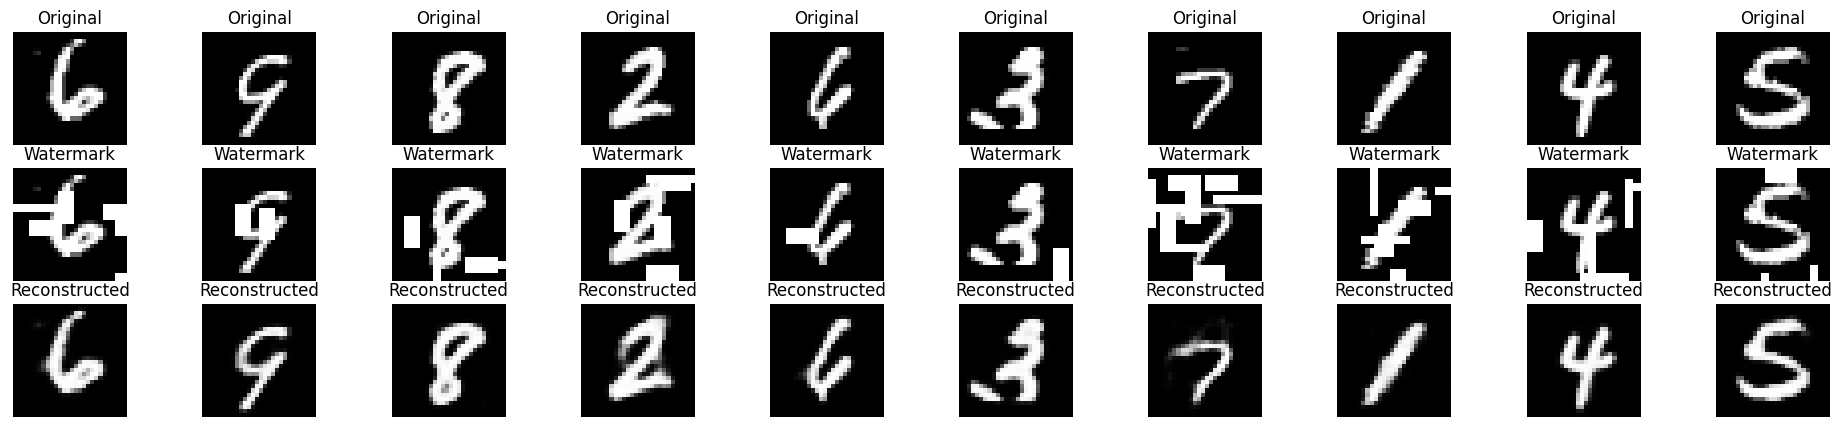

In [548]:
import matplotlib.pyplot as plt

def evaluate(model, device, criterion, xs_test, ys_test_true):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        xs = xs_test.to(device)
        ys_true = ys_test_true.to(device)
        ys_pred = model(xs)
        loss = criterion(ys_pred, ys_true)
        total_loss = loss.item()
        print(f'Test Loss: {total_loss:.4f}')

def visualize_reconstructions(model, device, xs_test, ys_test, num_images=10):

    index = 300

    model.eval()
    with torch.no_grad():
        xs = xs_test[index:index+num_images].to(device)
        ys_true = ys_test[index:index+num_images].to(device)        
        ys_pred = model(xs)

    xs = xs.cpu().numpy()
    
    ys_true = ys_true.cpu().numpy()
    ys_pred = ys_pred.cpu().numpy()

    plt.figure(figsize=(24, 5))
    for i in range(num_images):
        # Original
        plt.subplot(3, num_images, i + 1)
        plt.imshow(ys_true[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        # With watermark
        plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(xs[i].reshape(28, 28), cmap='gray')
        plt.title("Watermark")
        plt.axis('off')
        # Reconstructed
        plt.subplot(3, num_images, i + 1 + 2*num_images)
        plt.imshow(ys_pred[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

evaluate(model, device, criterion, xs_test, ys_test)
visualize_reconstructions(model, device, xs_test, ys_test)

# Watermarks

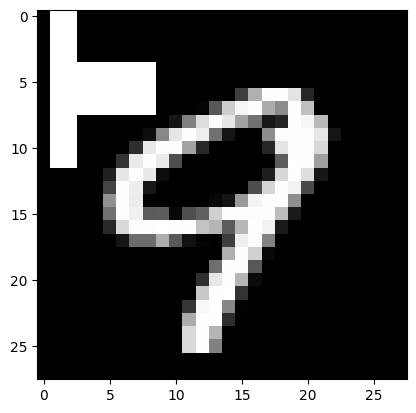

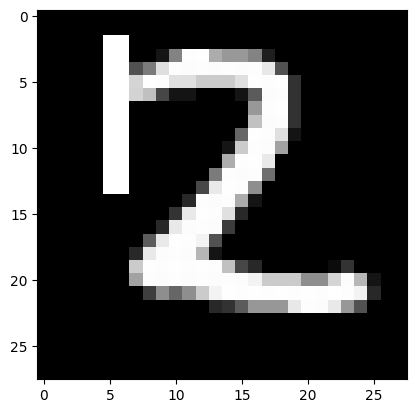

In [505]:
import random
import numpy as np

def add_watermark(images):
    images_with_watermark = np.copy(images)
    images_with_watermark = images_with_watermark.reshape(-1, 28, 28)
    num_images = len(images_with_watermark)
    
    mask = np.zeros((num_images, 28, 28), dtype=bool)
    for i in range(num_images):
        num_masks = random.randint(1, 3)
        for _ in range(num_masks):
            shapes = [[2,12], [12,2], [8,4], [4,8]]
            shape = random.choice(shapes)
            watermark_w = shape[0]
            watermark_h = shape[1]
            watermark_x = random.randint(0, 28)
            watermark_y = random.randint(0, 28)
            mask[i, watermark_x:watermark_x + watermark_w, watermark_y:watermark_y + watermark_h] = True

    images_with_watermark[mask] = 1   
    images_with_watermark = images_with_watermark.reshape(-1, 784)
    return images_with_watermark

def plot_image(image):
    plt.figure()
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.show()


size = 2
images = ys_train[100: 100 + size].cpu().numpy()
images = add_watermark(images)
for i in range(size):
    plot_image(images[i])